This notebook creates and then trains naive templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates, spectral_lines

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [5]:
def log_norm(x,mode,sigma):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1/x*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return f1(x)/f1(5000)

N = 16
n = 6
modes  = np.concatenate((np.linspace(5500,4600,n,endpoint=False),np.linspace(4600,1000,N-n)))
sigmas = np.concatenate((np.linspace(0.35,0.56,n,endpoint=False),np.linspace(0.56, 0.9,N-n)))

# save the templates as Seds
x = np.arange(10,15000,100,dtype=float)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i])
    naive_templates["naive"+str(i+1)] = template

Create training sets and plot them

In [10]:
%%time
training_sets = create_training_sets(naive_templates,galaxies,bandpass_dict)

CPU times: user 4min 24s, sys: 164 ms, total: 4min 24s
Wall time: 4min 24s


Number of fluxes in each training set:
[81560, 62677, 42502, 37915, 34875, 35336, 42156, 46045, 34764, 21919, 12826, 11179, 15478, 22602, 40364, 72230]


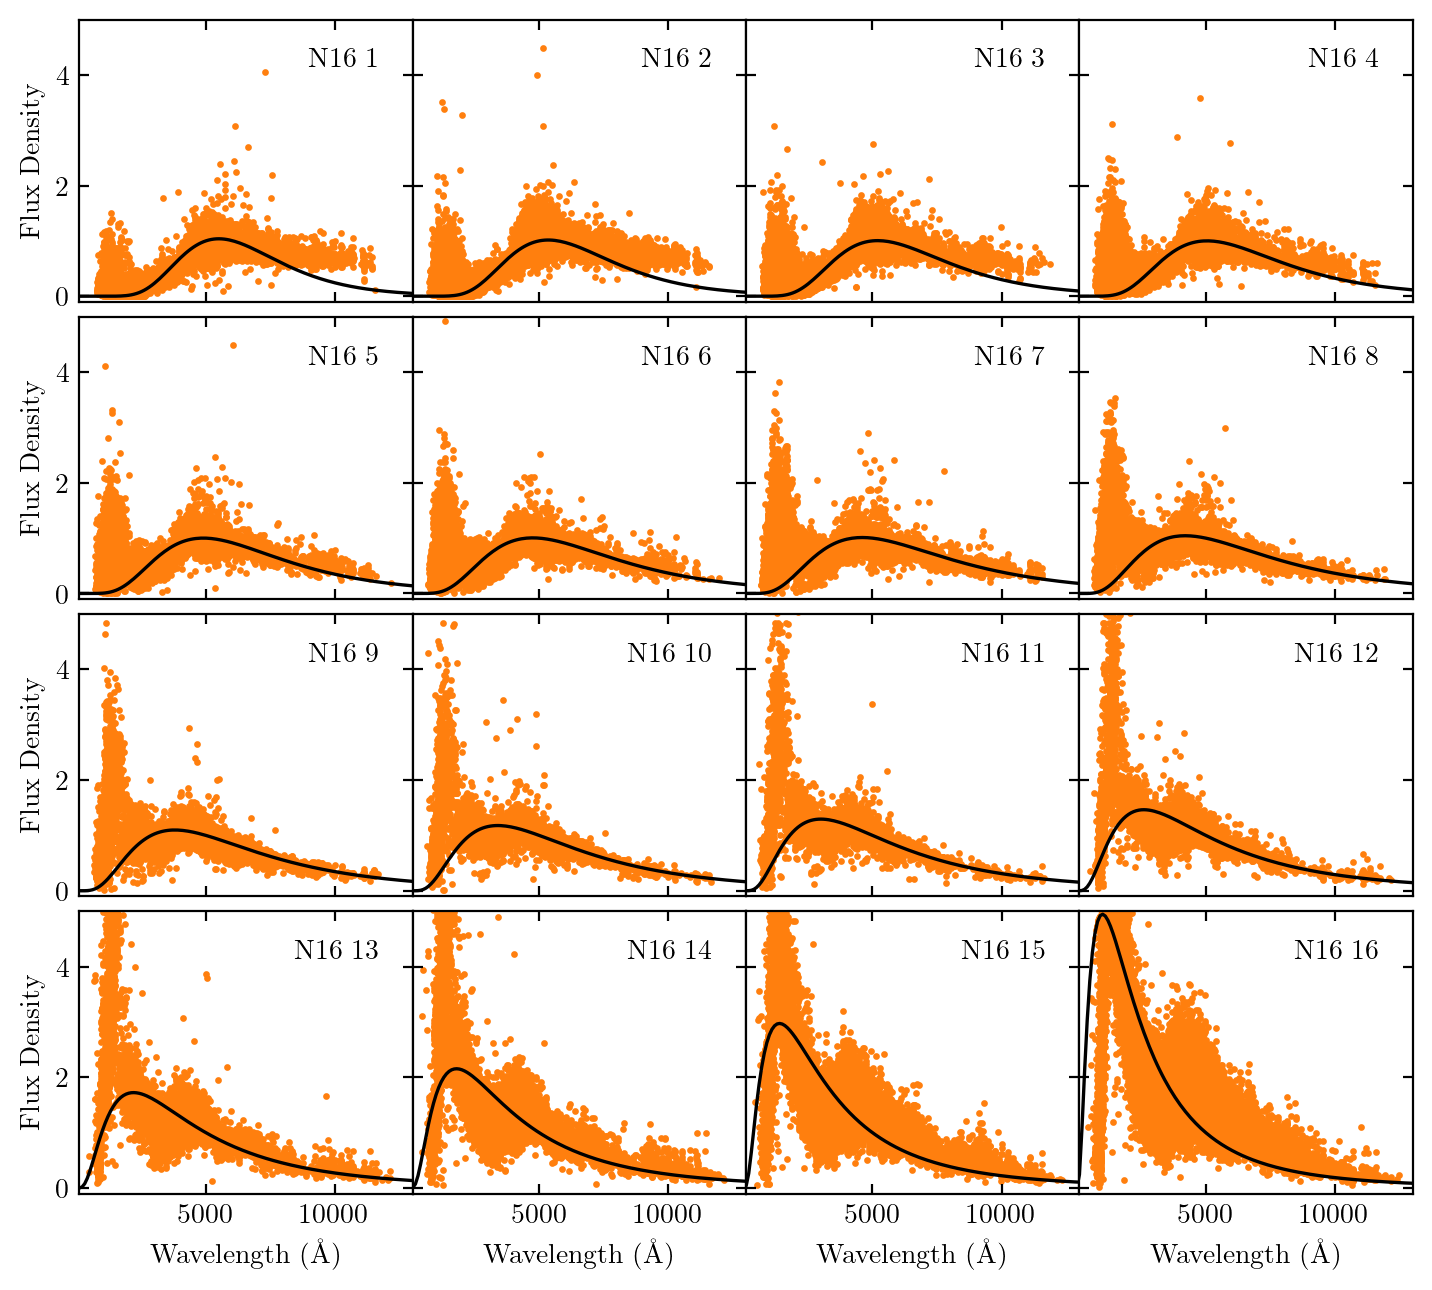

In [15]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.9))

print("Number of fluxes in each training set:")
print([len(i) for i in training_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in training_sets["naive"+str(i+1)]]
    fluxes  = [row[1] for row in training_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = naive_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,"N16 "+str(i+1),transform=ax.transAxes,ha="right",va="top")
    
    ax.set_xlim(100,13000)
    ax.set_ylim(-0.1,5)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0.15, w_pad=0)
plt.show()

#fig.savefig('plots/N16_untrained.png')

Now train the templates

In [6]:
%%time
trained_templates, final_sets = train_templates(naive_templates, galaxies, bandpass_dict, N_iter=3, w=0.5)

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Generating final sets
Done!
CPU times: user 1h 3min 51s, sys: 10.8 s, total: 1h 4min 2s
Wall time: 6h 12min 25s


Save the results!

In [8]:
"""for template in trained_templates:
    file = open('templates/'+template+'_16.sed','w')
    x = copy.copy(trained_templates[template].wavelen)
    y = copy.copy(trained_templates[template].flambda)
    # upsample to every 10 angstroms
    xnew = np.arange(x[0],x[-1],10)
    ynew = np.interp(xnew,x,y)
    for i in range(len(xnew)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(xnew[i],ynew[i]))
    file.close()"""

Plot the trained templates

In [6]:
# Load the trained templates from files if you didn't run the training algorithm
trained_templates = dict()
for template in naive_templates:
    x,y = np.loadtxt('templates/'+template+'_16.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(trained_templates, galaxies, bandpass_dict)

Number of fluxes in each training set:
[88666, 51570, 38299, 36485, 40092, 41243, 37398, 36843, 30904, 18822, 23906, 33074, 29745, 33463, 41995, 31923]


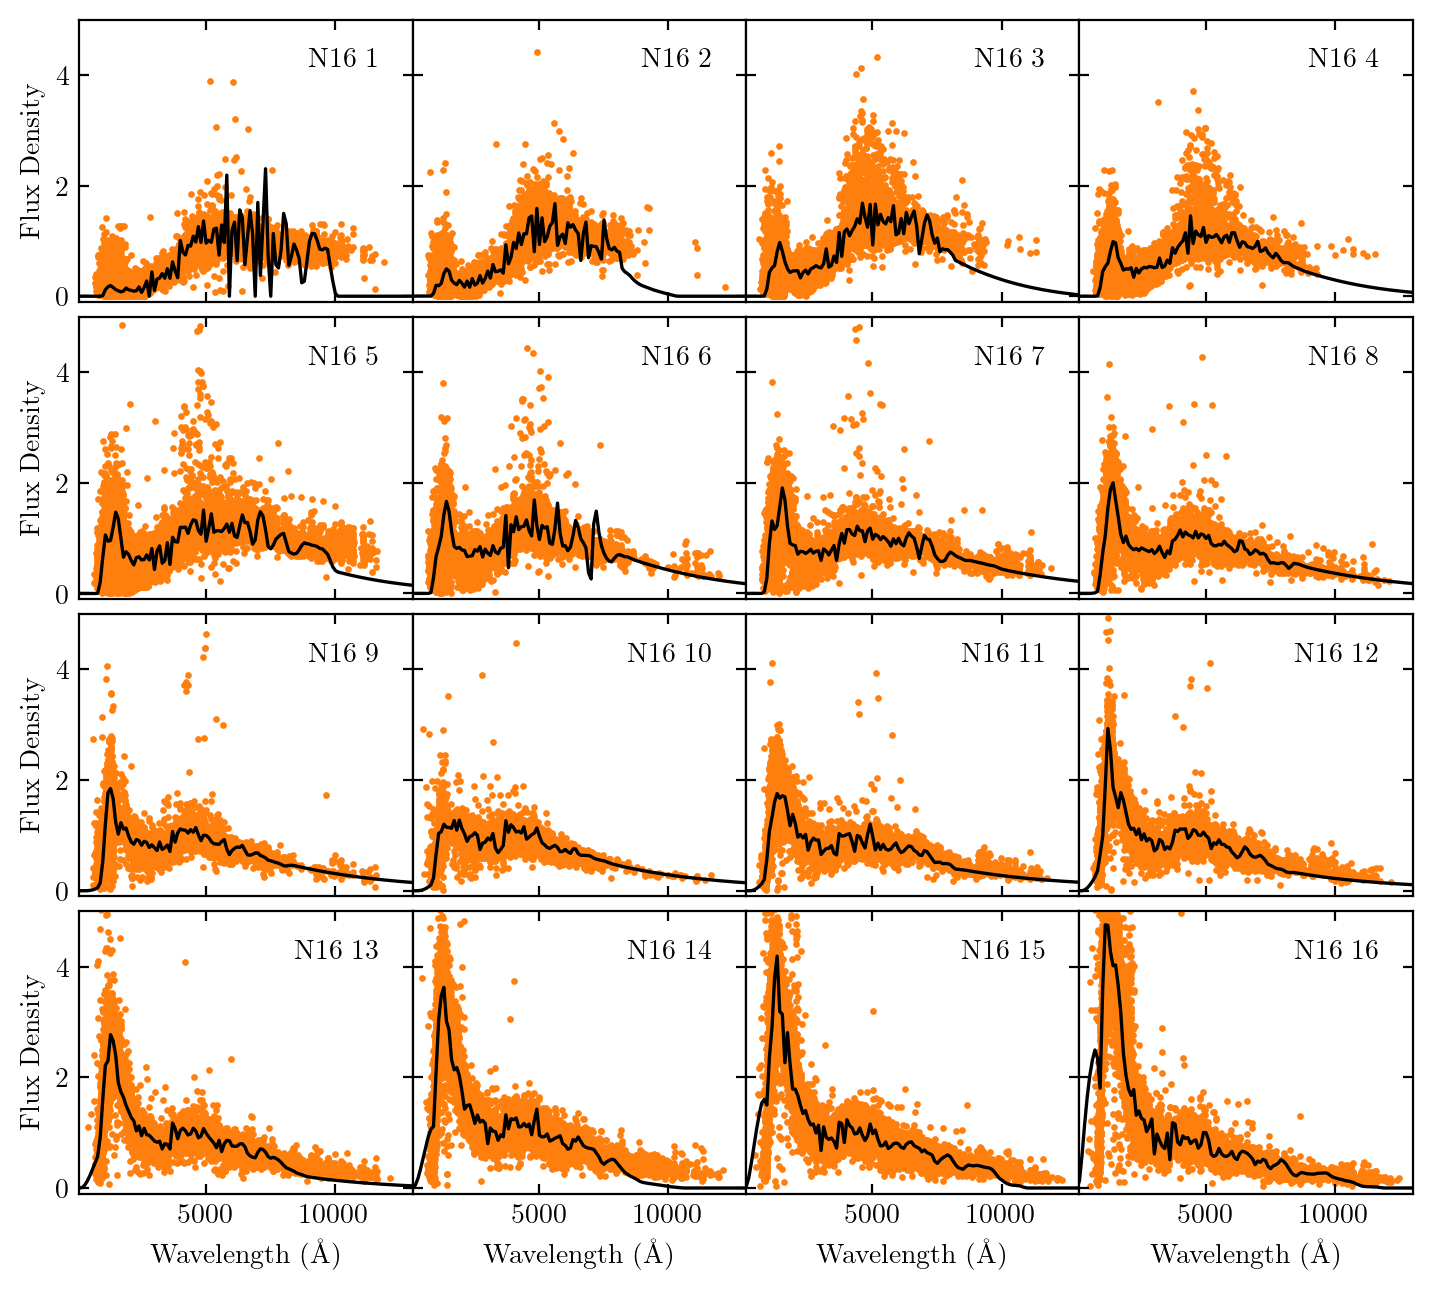

In [16]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.9))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in final_sets["naive"+str(i+1)]]
    fluxes  = [row[1] for row in final_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,"N16 "+str(i+1),transform=ax.transAxes,ha="right",va="top")
    
    ax.set_xlim(100,13000)
    ax.set_ylim(-0.1,5)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0.15, w_pad=0)
plt.show()

#fig.savefig('plots/N16_trained.png')

Some more plots...

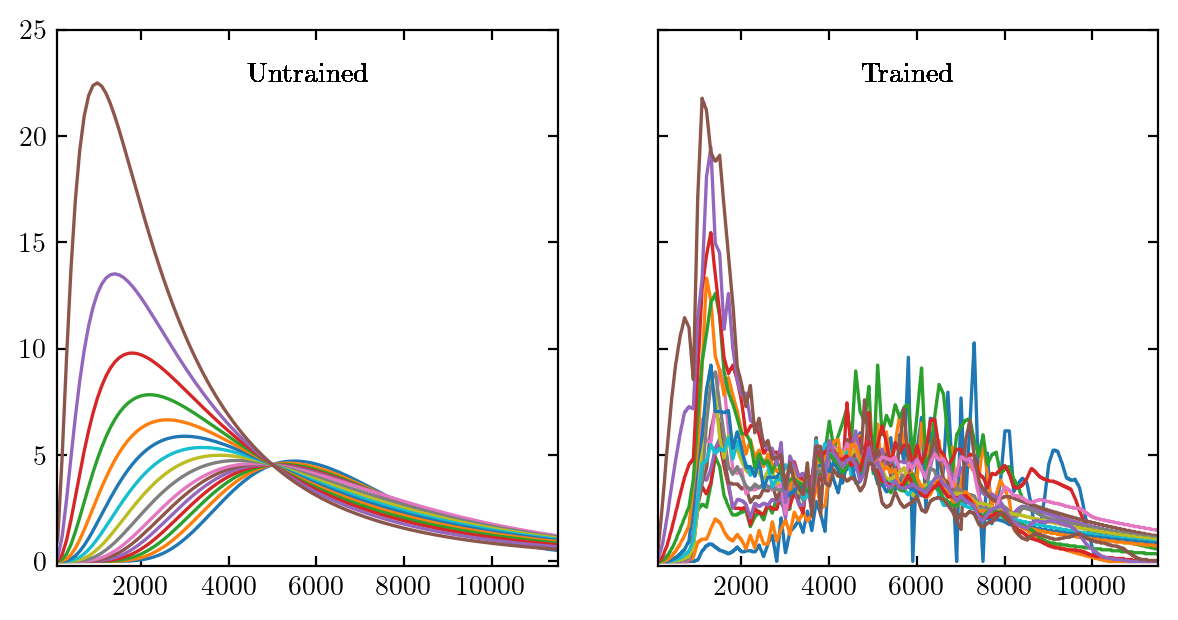

In [56]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex='all',sharey='all',figsize=(twocol,twocol/2))

for template in naive_templates.values():
    
    ax1.plot(template.wavelen,template.flambda/scale)
    ax1.text(0.5,0.9,"Untrained",transform=ax1.transAxes,ha="center")

for template in trained_templates.values():

    ax2.plot(template.wavelen,template.flambda/scale)    
    ax2.text(0.5,0.9,"Trained",transform=ax2.transAxes,ha="center")
    
plt.ylim(-0.2,25)
plt.xlim(100,11500)
plt.show()

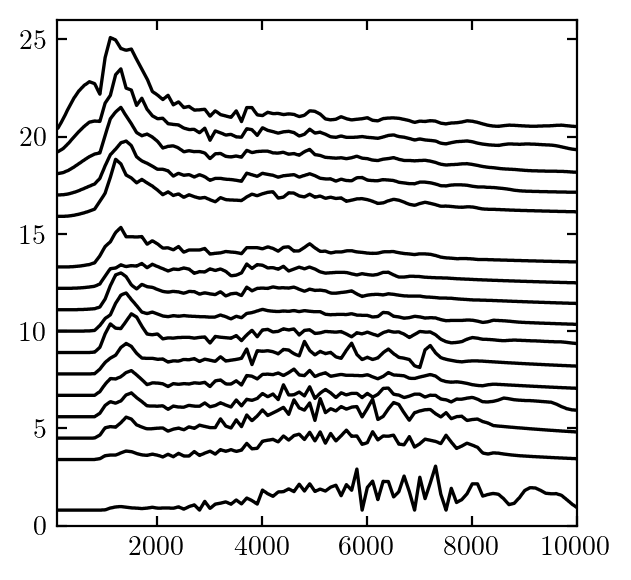

In [98]:
fig,ax = plt.subplots()
    
for i,template in enumerate(trained_templates.values()):
    
    offset = 1.1*i + 0.8
    if i > 0:
        offset += 1.5
    #if i > 1:
    #    offset += 6
    if i > 10:
        offset += 1.5
    #if i == 19:
    #    offset += 4
        
    x = template.wavelen
    y = template.flambda
    ax.plot(x,y+offset,c='k')
    #ax.text(x[-1]+100,y[-1]+offset,str(i+1),va='center',ha='left')
    
#ax.vlines([3727,4000,4861,4959,5007,6583],0,100,color='silver',ls='--')
    
plt.ylim(0,26)
plt.xlim(100,10000)
plt.show()